# Problem Description

Objective: Generate a Simulation model that outputs the performance measures, such as average length, average waiting time, utilization of the system, etc. to provide information for designing or improving service facilities.
Data:
* λ: the arrival rate (the expected number of consecutive arrivals per the same unit time, e.g. 1 minute)
* μ: the service rate (the expected number of consecutive service completions per the same unit time, e.g. 1 minute)
* the distribution of the data
* c: the number of servers = 1

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# set seed for reproducibility
np.random.seed(0)



In [2]:
#Single server queue simulation
l = 1 # average number of arrivals per hour
µ = 1.5 # average number of people served per hour
ncust = 1000 # number of customers
c = 1 # number of servers
    

For this project the data will be generated using random number generation, in an actual study the rates should be modeled from real data to get more accurate results.

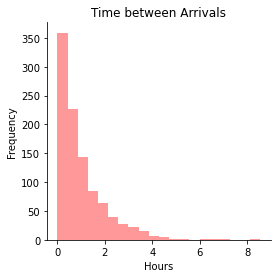

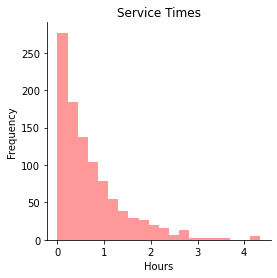

In [3]:
# Generating inter arrival times using exponential distribution
inter_arrival_times = list(np.random.exponential(scale=1/l,size=ncust))

#plotting data
plt.figure(figsize=(4,4))
sns.distplot(inter_arrival_times, kde=False, color='r', bins=20)
plt.title('Time between Arrivals')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()

# Generate random service times for each customer 
service_times = list(np.random.exponential(scale=1/µ, size=ncust))

#service time distribution plot
plt.figure(figsize=(4,4))
sns.distplot(service_times, kde=False, color='r', bins=20)
plt.title('Service Times')
plt.xlabel('Hours')
plt.ylabel('Frequency')
sns.despine()
plt.show()


In [4]:
arrival_times = [] # list of arrival times of a person joining the queue
finish_times = [] # list of finish times after waiting and being served

arrival_times = [0 for i in range(ncust)]
finish_times = [0 for i in range(ncust)]

arrival_times[0] = round(inter_arrival_times[0], 4) #arrival of first customer# 

# Generate arrival times
for i in range(1, ncust):
    arrival_times[i] = round((arrival_times[i-1] + inter_arrival_times[i]), 4)


In [5]:
#Generating finish times
finish_times[0]= round((arrival_times[0] + service_times[0]),4)
for i in range(1,ncust):
    previous_finish=finish_times[:i]
    previous_finish.sort(reverse=True)
    previous_finish=previous_finish[:c]
    if i< c:
        finish_times[i] = round(arrival_times[i] + service_times[i],4)
    else:
        finish_times[i]=round((max(arrival_times[i],min(previous_finish))+service_times[i]),4)    

In [6]:
# Total time spent in the system by each customer
total_times =[abs(round((finish_times[i]-arrival_times[i]),4)) for i in range(ncust)]

# Time spent waiting before being served (time spent in the queue)
wait_times = [abs(round((total_times[i] - service_times[i]),4)) for i in range (ncust)]


In [7]:
# creating a dataframe with all the data of the model
#df = pd.DataFrame({'waiting_times':wait_times})
df = pd.DataFrame(list(zip(arrival_times, finish_times, service_times, total_times, wait_times, inter_arrival_times)),
                 columns =['arrival_times', 'finish_times', 'service_times', 'total_times', 'wait_times', 'inter_arrival_times' ])

# print the first 5 rows of the data
df.head()

,arrival_times,finish_times,service_times,total_times,wait_times,inter_arrival_times
0,0.7959,1.3950,0.599099,0.5991,0.0000,0.795875
1,2.0518,2.0585,0.006743,0.0067,0.0000,1.255931
2,2.9750,3.4056,0.430621,0.4306,0.0000,0.923223
3,3.7622,4.5846,0.822429,0.8224,0.0000,0.787201
4,4.3132,4.6146,0.029981,0.3014,0.2714,0.551048


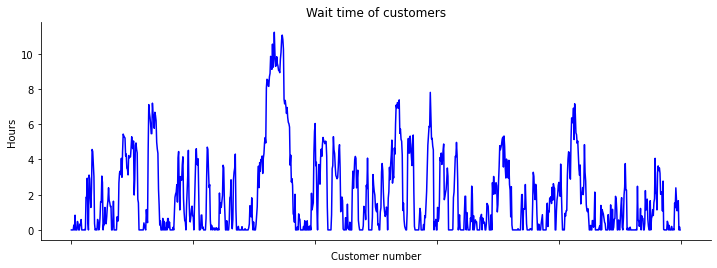

In [8]:
# plotting Wait times
plt.figure(figsize=(12,4))
sns.lineplot(x=df.index, y=wait_times, color='blue').set(xticklabels=[])
plt.xlabel('Customer number')
plt.ylabel('Hours')
plt.title('Wait time of customers')
sns.despine()
plt.show()

In [9]:
tbe = list([0])
timeline = ['simulation starts']
for i in range(0, ncust):
    tbe.append(df['arrival_times'][i])
    tbe.append(df['finish_times'][i])
    timeline.append('customer ' +str(i+1)+ ' arrived')
    timeline.append('customer ' +str(i+1)+ ' left')
    

# generating a dataframe with the timeline and description of events

timeline = pd.DataFrame(list(zip(tbe, timeline)),
                        columns = ['time', 'Timeline']).sort_values(by = 'time').reset_index()

timeline = timeline.drop(columns='index')

# printing the first 5 rows of the data
timeline.head()

,time,Timeline
0,0.0000,simulation starts
1,0.7959,customer 1 arrived
2,1.3950,customer 1 left
3,2.0518,customer 2 arrived
4,2.0585,customer 2 left


In [10]:
# generating the number of customers inside the system at any given time of the simulation

timeline['n'] = 0
x=0
for i in range(1,(2*ncust)-1):
    if len((timeline.Timeline[i]).split()) > 2:
        z = str(timeline['Timeline'][i]).split()[2]
    else:
        continue
    if z == 'arrived':
        x = x + 1
        timeline['n'][i] = x
    else:
        x = x-1
        if x == -1:
            x = 0
            timeline['n'][i] = x
        
   

In [11]:
# computing time between events
t = list()
for i in timeline.index:
    if i == (2*ncust) - 2:
        continue
    if i < 2*ncust:
        x = timeline.time[i+1]
    else:
        x = timeline.time[i]
    y = timeline.time[i]
    t.append(round((x-y), 4))

t.append(0)
timeline['tbe'] = t
    

In [12]:
#show results
timeline.head()

,time,Timeline,n,tbe
0,0.0000,simulation starts,0,0.7959
1,0.7959,customer 1 arrived,1,0.5991
2,1.3950,customer 1 left,0,0.6568
3,2.0518,customer 2 arrived,1,0.0067
4,2.0585,customer 2 left,0,0.9165


In [13]:
# computing the probability and time spent of 'n' customers in the system

Pn = timeline.groupby('n').tbe.agg(sum)/sum(t)
Tn = timeline.groupby('n').tbe.agg('count')
timeline.groupby('n').tbe.agg(sum)/sum(t)


n
0     0.594672
1     0.118800
2     0.071186
3     0.041728
4     0.042240
5     0.033914
6     0.023136
7     0.026194
8     0.016830
9     0.007583
10    0.005321
11    0.002999
12    0.005447
13    0.000959
14    0.003017
15    0.003496
16    0.001231
17    0.001247
Name: tbe, dtype: float64

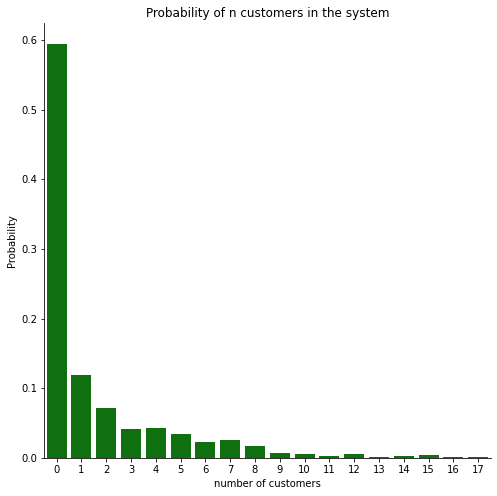

In [14]:
# plotting results
plt.figure(figsize=(8,8))
sns.barplot(x=Pn.index, y=Pn, color='g')
plt.title('Probability of n customers in the system')
plt.xlabel('number of customers')
plt.ylabel('Probability')
sns.despine()
plt.show()

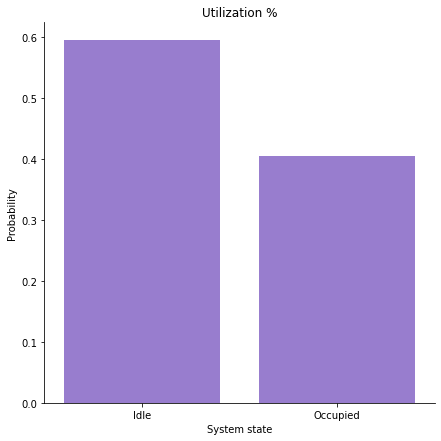

In [15]:
plt.figure(figsize=(7,7))
sns.barplot(['Idle','Occupied'],[Pn[0],1-Pn[0]],color='mediumpurple')
plt.title('Utilization %')
plt.xlabel('System state')
plt.ylabel('Probability')
sns.despine()
plt.show()

In [16]:
# computing expected number of customers in the system
Ls = (sum(Pn*Pn.index))

#computing expected customers waiting in line
Lq = sum((Pn.index[c+1:]-1)*(Pn[c+1:]))

In [17]:
# Model Results
print('Output:','\n',
      'Servers: '+str(c), '\n'
      'Time Between Arrivals : ',str(df.inter_arrival_times.mean()),'\n',
      'Service Time: (1/µ)',str(df.service_times.mean()),'\n'
      ' Utilization (c): ',str((Ls-Lq)/c),'\n',
      'Expected wait time in line (Wq):',str(df['wait_times'].mean()),'\n',
      'Expected time spent on the system (Ws):',str(df.total_times.mean()),'\n',
      'Expected number of customers in line (Lq):',str(Lq),'\n',
      'Expected number of clients in the system (Ls):',str(Ls),'\n ')
      

Output: 
 Servers: 1 
Time Between Arrivals :  1.003540208760709 
 Service Time: (1/µ) 0.7107006852820134 
 Utilization (c):  0.4053280567972184 
 Expected wait time in line (Wq): 1.9202734000000001 
 Expected time spent on the system (Ws): 2.6309737999999996 
 Expected number of customers in line (Lq): 1.144226792753855 
 Expected number of clients in the system (Ls): 1.5495548495510734 
 
